## MODELOS ARIMA & LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN TOTAL EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

Importamos las librerias necesarias

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Importamos la data de Demanda de gas total como un CSV

Se lee la data "original" de Demanda total

In [141]:
demanda_total_original = pd.read_csv('Demanda_total_2023.csv',index_col='Date',parse_dates=True)
demanda_total_original

,Demanded_Gas
Date,
2005-01-01,5176.015
2005-02-01,5258.329
2005-03-01,4971.291
2005-04-01,4934.576
2005-05-01,5160.325
...,...
2023-05-01,8193.326
2023-06-01,8913.460
2023-07-01,8031.150


Se grafica la data "original" de Demanda total de GN

Text(0, 0.5, 'Demanda [MMpcd]')

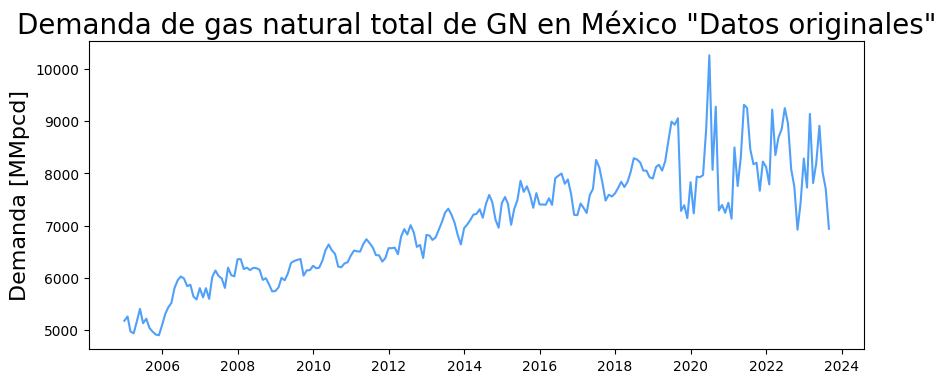

In [144]:
plt.figure(figsize=(10,4))
plt.plot(demanda_total_original, color='#50A0FA')
plt.title('Demanda de gas natural total de GN en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda total de GN en sus compoentes de Tendencia, Estacionalidad y Residual

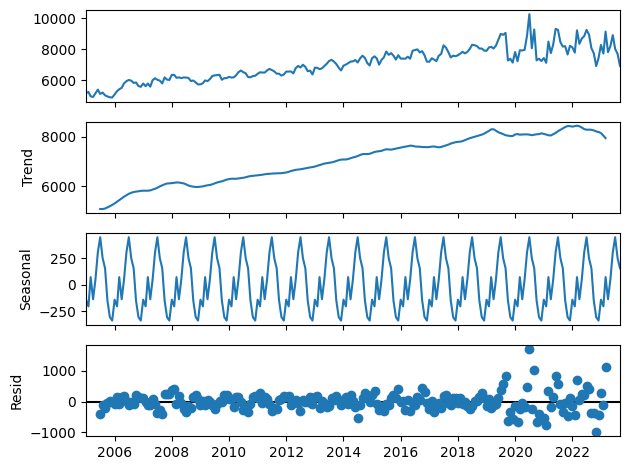

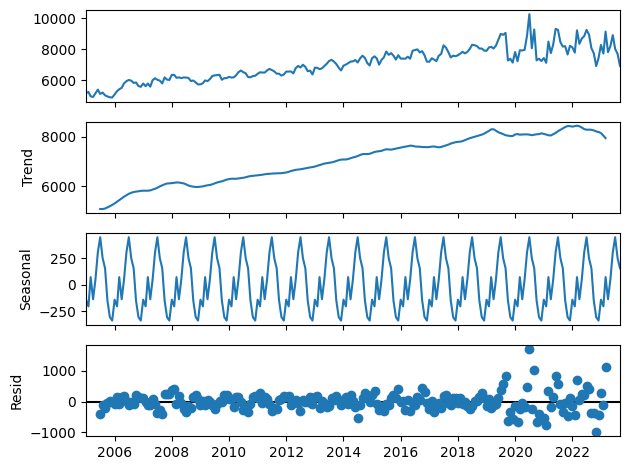

In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_total_original_seasonal_decomposition = seasonal_decompose(demanda_total_original)
demanda_total_original_seasonal_decomposition.plot()

Separamos la data original de Demanda total de GN en data de train y test

In [146]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_total_original_train_data = demanda_total_original[:-num_test_points]
demanda_total_original_test_data = demanda_total_original[-num_test_points:]
demanda_total_original_train_data

,Demanded_Gas
Date,
2005-01-01,5176.015
2005-02-01,5258.329
2005-03-01,4971.291
2005-04-01,4934.576
2005-05-01,5160.325
...,...
2022-05-01,8692.273
2022-06-01,8851.433
2022-07-01,9252.496


Se grafica la distribución de los datos "originales" de train de Demanda total de GN

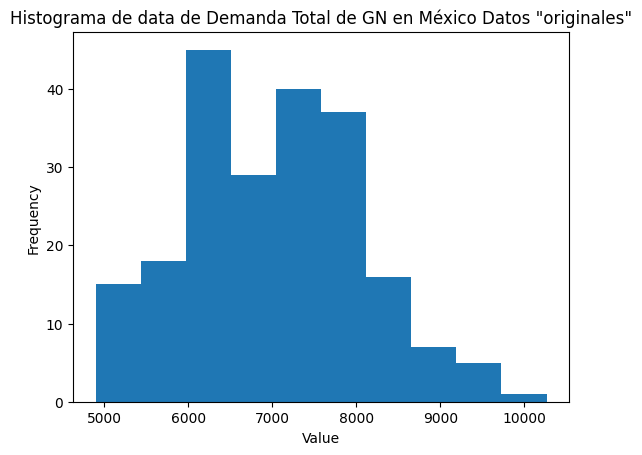

In [149]:
# Generate the histogram
plt.hist(demanda_total_original_train_data, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda Total de GN en México Datos "originales"')

# Display the plot
plt.show()

In [150]:
demanda_total_original_train_data.describe()

,Demanded_Gas
count,213.000000
mean,6997.896953
std,1044.169430
min,4897.946000
25%,6193.127000
50%,7022.791000
75%,7753.503000
max,10265.421000


In [151]:
mean_demanda_total_original_train_data =  demanda_total_original_train_data.describe().values[1]
mean_demanda_total_original_train_data

array([6997.89695305])

In [152]:
st_demanda_total_original_train_data =  demanda_total_original_train_data.describe().values[2]
st_demanda_total_original_train_data

array([1044.16942962])

In [153]:
mean_demanda_total_original_train_data / st_demanda_total_original_train_data

array([6.70187879])

Se lleva a cabo una prueba de normalidad a los datos "originales" de train de Demanda total de GN

In [154]:
import scipy.stats as stats

# Assuming demanda_total_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_total_original_train_data

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 2.23522287328912
p-value: 0.32706006607702903


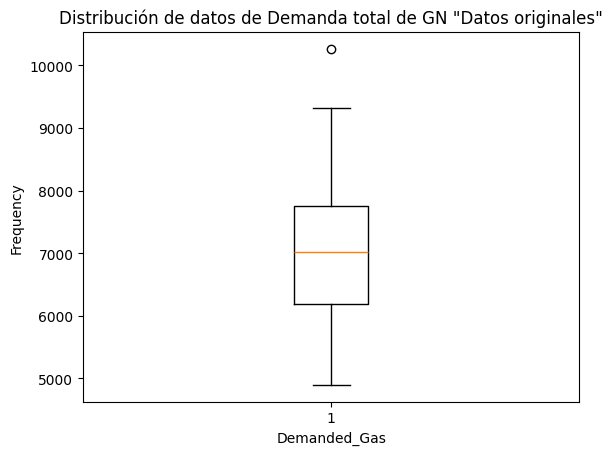

In [156]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_total_original_train_data)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda total de GN "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [157]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [158]:
demanda_total_original_train_data["Demanded_Gas"]

Date
2005-01-01    5176.015
2005-02-01    5258.329
2005-03-01    4971.291
2005-04-01    4934.576
2005-05-01    5160.325
                ...   
2022-05-01    8692.273
2022-06-01    8851.433
2022-07-01    9252.496
2022-08-01    8957.842
2022-09-01    8078.561
Name: Demanded_Gas, Length: 213, dtype: float64

In [159]:
n_input = 24

data = demanda_total_original_train_data["Demanded_Gas"]
targets = data 


demanda_total_original_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [160]:
print("Total number of samples in the original training data = ", len(demanda_total_original_train_data)) 
print("Total number of samples in the demanda_total_train_generator = ", len(demanda_total_original_train_generator))


Total number of samples in the original training data =  213
Total number of samples in the demanda_total_train_generator =  189


In [162]:
demanda_total_original_train_generator[200]

(array([], dtype=float64), array([], dtype=float64))

### Se define y entrena la red neuronal FNN  para el caso de la data original de Demanda total GN

In [163]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [164]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

Se define la red neuronal FFNN con capas densas y funcion de activación tipo RELU.

In [165]:
n_input = n_input 
n_features = 1

# define model
model_FF_total_sin_tratamiento = Sequential()
model_FF_total_sin_tratamiento.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_FF_total_sin_tratamiento.add(Dense(32, activation='relu'))
model_FF_total_sin_tratamiento.add(Dense(1))
model_FF_total_sin_tratamiento.compile(optimizer='Adam', loss='mse')

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [166]:
model_FF_total_sin_tratamiento.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 24, 64)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [167]:
model_FF_total_sin_tratamiento.fit(demanda_total_original_train_generator, epochs=12)

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


Epoch 1/12
 41/189 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36298832.0000

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17383852.0000
Epoch 2/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 387131.2188
Epoch 3/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 333607.0625
Epoch 4/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 316561.8125
Epoch 5/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 284177.7500
Epoch 6/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 311390.8750
Epoch 7/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 335784.4062
Epoch 8/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 347311.1875
Epoch 9/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 338734.9062
Epoch 10/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 402433.2500
Epoch 11/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 505982.7188
Epoch 12/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 267110.0938


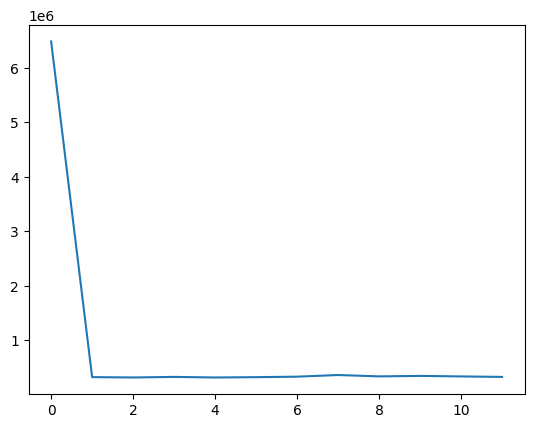

In [168]:
loss_per_epoch_model_FF = model_FF_total_sin_tratamiento.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [27]:
n_input = n_input
n_features = n_features

In [169]:
test_predictions_model_FF_total_sin_pretratamiento = []

first_eval_batch = demanda_total_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_total_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_FF_total_sin_tratamiento.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_FF_total_sin_pretratamiento.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [170]:
test_predictions_model_FF_total_sin_pretratamiento

[8220.341,
 8364.587,
 8511.343,
 8660.651,
 8812.558,
 8967.105,
 9124.343,
 9284.315,
 9447.071,
 9612.658,
 9781.125,
 9952.523]

Text(0, 0.5, 'Demanda [MMpcd]')

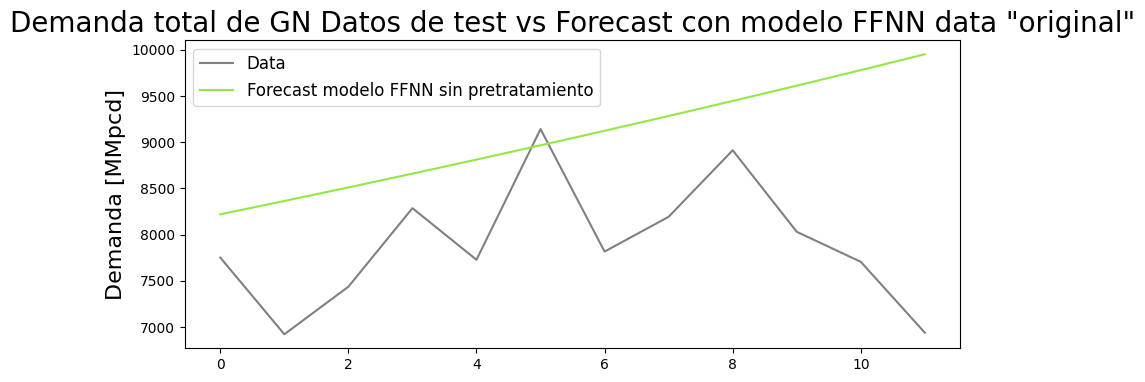

In [171]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_total_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_FF_total_sin_pretratamiento, color='#94E844')
plt.legend(('Data', 'Forecast modelo FFNN sin pretratamiento'), fontsize=12)

plt.title('Demanda total de GN Datos de test vs Forecast con modelo FFNN data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda total de GN

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [172]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [173]:
n_input = n_input
n_features = n_features

In [174]:
# define model
model_LSTM_total_original = Sequential()
model_LSTM_total_original.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_total_original.add(Dense(1))
model_LSTM_total_original.compile(optimizer='adam', loss='mse')

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [175]:
model_LSTM_total_original.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo LSTM

In [176]:
model_LSTM_total_original.fit(demanda_total_original_train_generator, epochs=12)


Epoch 1/12


c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 32116148.0000
Epoch 2/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 21208568.0000
Epoch 3/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 16291156.0000
Epoch 4/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 875702.6875
Epoch 5/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 994633.1875 
Epoch 6/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 234718.4531
Epoch 7/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 238690.1406
Epoch 8/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 257326.6094
Epoch 9/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 221429.5000
Epoch 10/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 226901.5156
Epoch 11/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 258260.2812
Epoch 12/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 220599.2188


Se grafica la perdida por epoch

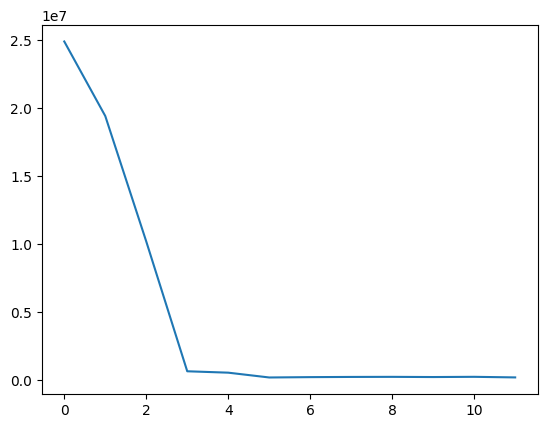

In [177]:
loss_per_epoch_model_FF = model_LSTM_total_original.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_residencialindustrial_original previamente definido y entrenado

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [37]:
n_input = n_input
n_features = n_features

In [178]:
test_predictions_model_LSTM_total_original = []

first_eval_batch = demanda_total_original_train_data[-n_input:]["Demanded_Gas"].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_total_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_total_original.predict(current_batch)[0]

    print("Current_batch is:")
    print(current_batch)
    print("************************************************************************")
    print("Current_pred is:")
    print(current_pred)
    # append the prediction into the array
    test_predictions_model_LSTM_total_original.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Current_batch is:
[[[7290.056]
  [7395.813]
  [7245.577]
  [7438.808]
  [7132.971]
  [8497.784]
  [7757.688]
  [8305.158]
  [9316.1  ]
  [9255.921]
  [8464.915]
  [8176.696]
  [8204.94 ]
  [7668.455]
  [8227.622]
  [8126.255]
  [7790.445]
  [9224.254]
  [8352.515]
  [8692.273]
  [8851.433]
  [9252.496]
  [8957.842]
  [8078.561]]]
************************************************************************
Current_pred is:
[8251.614]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Current_batch is:
[[[7395.813     ]
  [7245.577     ]
  [7438.808     ]
  [7132.971     ]
  [8497.784     ]
  [7757.688     ]
  [8305.158     ]
  [9316.1       ]
  [9255.921     ]
  [8464.915     ]
  [8176.696     ]
  [8204.94      ]
  [7668.455     ]
  [8227.622     ]
  [8126.255     ]
  [7790.445     ]
  [9224.254     ]
  [8352.515     ]
  [8692.273     ]
  [8851.433     ]
  [9252.496     ]
  [8957.842     ]
  [8078.561     ]
  [8251.61425781]]]
**************************************

In [179]:
test_predictions_model_LSTM_total_original

[array([8251.614], dtype=float32),
 array([8249.283], dtype=float32),
 array([8280.383], dtype=float32),
 array([8548.844], dtype=float32),
 array([8616.527], dtype=float32),
 array([8835.192], dtype=float32),
 array([8539.971], dtype=float32),
 array([8704.816], dtype=float32),
 array([9239.661], dtype=float32),
 array([8763.719], dtype=float32),
 array([8673.401], dtype=float32),
 array([9069.042], dtype=float32)]

Se grafican los 12 meses de test vs el forecast del modelo LSTM con la data de entrenamiento 

Text(0, 0.5, 'Demanda [MMpcd]')

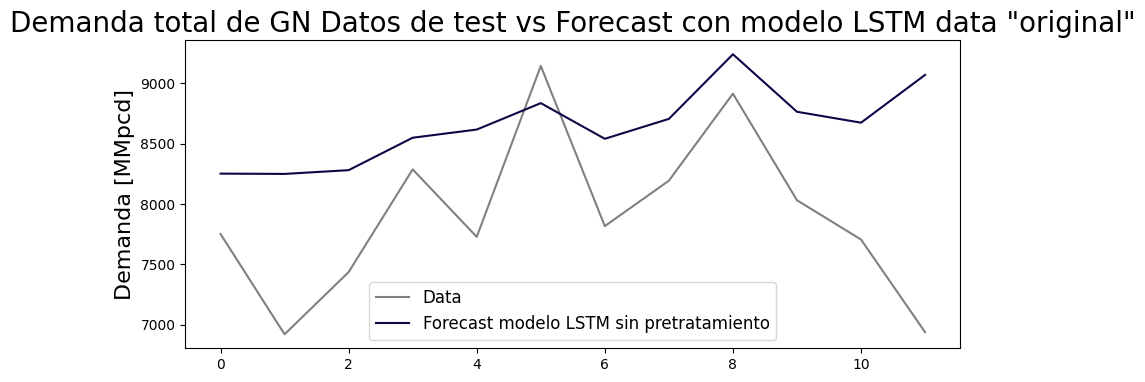

In [181]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_total_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_total_original, color='#150347')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento'), fontsize=12)

plt.title('Demanda total de GN Datos de test vs Forecast con modelo LSTM data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo LSTM sin la data pretratada

In [182]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_total_original = mean_absolute_percentage_error(demanda_total_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_total_original)
RMSE_predictions_model_LSTM_total_original = np.sqrt(mean_squared_error(demanda_total_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_total_original))

print('MAPE:', MAPE_predictions_model_LSTM_total_original)
print('RMSE:', RMSE_predictions_model_LSTM_total_original)

MAPE: 0.10543038717212479
RMSE: 938.8120113485637


Proceso para decidir el modelo ARIMA a aplicar en el caso de (SIN pretratamiento de atípicos)

Se verifica la estacionariedad de la data original con ayuda de la prueba de Dickey-Fuller

In [183]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_total_original_sin_diferenciar = adfuller(demanda_total_original)


adf_test_total_original_sin_diferenciar

(-2.3871892775982415,
 0.1453848336251367,
 13,
 211,
 {'1%': -3.46172743446274,
  '5%': -2.8753374677799957,
  '10%': -2.574124089081557},
 3002.337100307427)

In [184]:
print(f"The ADF statistic value f is: {adf_test_total_original_sin_diferenciar[0]}")

print(f"The ADF p value p is: {adf_test_total_original_sin_diferenciar[1]}")

if adf_test_total_original_sin_diferenciar[0] < adf_test_total_original_sin_diferenciar[4]['5%']:
    print("Se rechaza H0: SI existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: NO existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -2.3871892775982415
The ADF p value p is: 0.1453848336251367
Se acepta H0: NO existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad


Se procede a hacer la primer diferencia para lograr estacionariedad 

In [185]:
demanda_total_original_diff1 = demanda_total_original.diff()
demanda_total_original_diff1

,Demanded_Gas
Date,
2005-01-01,NaN
2005-02-01,82.314
2005-03-01,-287.038
2005-04-01,-36.715
2005-05-01,225.749
...,...
2023-05-01,376.262
2023-06-01,720.134
2023-07-01,-882.310


Se verifica la estacionariedad de la data original CON UNA DIFERENCIA con ayuda de la prueba de Dickey-Fuller

In [186]:

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_total_original_con_diferencia = adfuller(demanda_total_original_diff1.dropna())


adf_test_total_original_con_diferencia

(-4.186278028345386,
 0.000695040865594837,
 12,
 211,
 {'1%': -3.46172743446274,
  '5%': -2.8753374677799957,
  '10%': -2.574124089081557},
 2991.0247608897275)

In [187]:
print(f"The ADF statistic value f is: {adf_test_total_original_con_diferencia[0]}")

print(f"The ADF p value p is: {adf_test_total_original_con_diferencia[1]}")

if adf_test_total_original_con_diferencia[0] < adf_test_total_original_con_diferencia[4]['5%']:
    print("Se rechaza H0: SI existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: NO existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -4.186278028345386
The ADF p value p is: 0.000695040865594837
Se rechaza H0: SI existe suficiente evidencia para rechazar H0 que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad


Se realizan las gráficas ACF & PACF para determinar el tipo de modelo ARIMA a implementar 

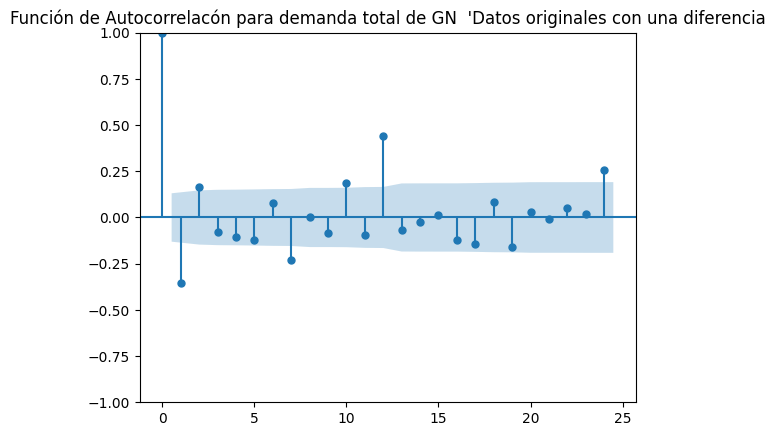

In [188]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_acf(demanda_total_original_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón para demanda total de GN  'Datos originales con una diferencia")

# Show the plot
plt.show()

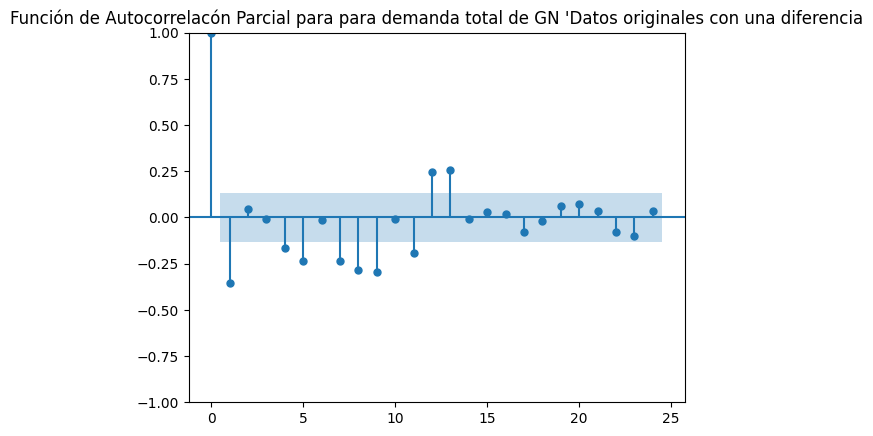

In [189]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_pacf(demanda_total_original_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón Parcial para para demanda total de GN 'Datos originales con una diferencia")

# Show the plot
plt.show()

### Se define y entrena modelo ARIMA para el caso de la data original de Demanda en el sector residencial & autotrasnporte

In [191]:
##Create the model
model_ARIMA_total_original = ARIMA (demanda_total_original_train_data, order=(4,1,2))

##Fit the model
start = time()
model_ARIMA_total_original_fit = model_ARIMA_total_original.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_total_original_fit.summary())

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\sta

Model fitting time 2.011863946914673
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1525.616
Date:                Mon, 13 May 2024   AIC                           3065.231
Time:                        15:20:21   BIC                           3088.727
Sample:                    01-01-2005   HQIC                          3074.728
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0743      0.076     14.055      0.000       0.925       1.224
ar.L2         -0.0707      0.071     -1.000      0.317      -0.209       0.068
ar.L3         -

In [192]:
##get prediction start and end dates 
pred_model_ARIMA_total_start_date = demanda_total_original_test_data.index[0]
pred_model_ARIMA_total_end_date = demanda_total_original_test_data.index[-1]

##get the predictors and residuals 
predictions_model_ARIMA_total_original = model_ARIMA_total_original_fit.predict(start=pred_model_ARIMA_total_start_date, end= pred_model_ARIMA_total_end_date)
predictions_model_ARIMA_total_original


2022-10-01    8327.189035
2022-11-01    8104.779135
2022-12-01    8154.961255
2023-01-01    8256.555117
2023-02-01    8399.886107
2023-03-01    8558.683030
2023-04-01    8681.727759
2023-05-01    8746.097495
2023-06-01    8740.056143
2023-07-01    8671.603186
2023-08-01    8563.525530
2023-09-01    8446.173414
Freq: MS, Name: predicted_mean, dtype: float64

In [193]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_total_original = mean_absolute_percentage_error(demanda_total_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_total_original)
RMSE_predictions_model_ARIMA_total_original = np.sqrt(mean_squared_error(demanda_total_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_total_original))

print('MAPE:', MAPE_predictions_model_ARIMA_total_original)
print('RMSE:', RMSE_predictions_model_ARIMA_total_original)

MAPE: 0.09182812511330822
RMSE: 792.683725695569


Text(0, 0.5, 'Demanda [MMpcd]')

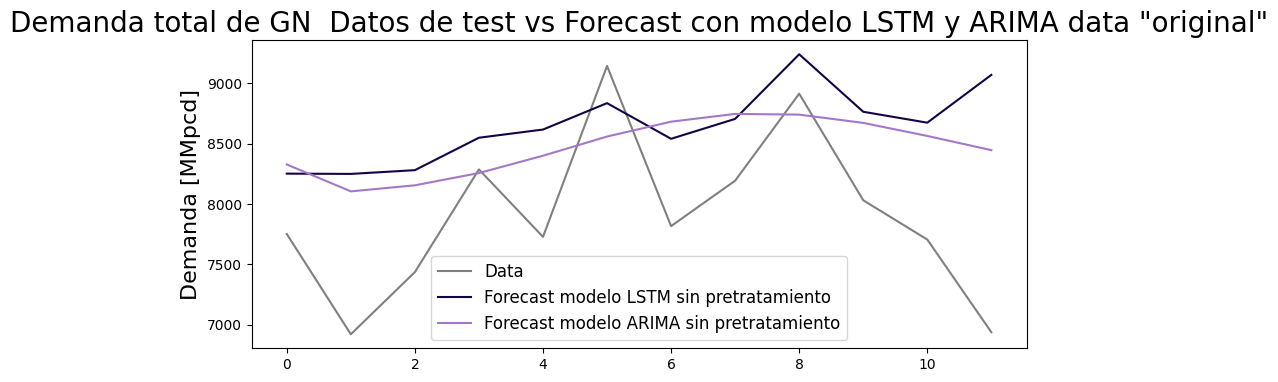

In [195]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_total_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_total_original, color='#150347')
plt.plot(predictions_model_ARIMA_total_original.values, color='#A478C8')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento', 'Forecast modelo ARIMA sin pretratamiento'), fontsize=12)

plt.title('Demanda total de GN  Datos de test vs Forecast con modelo LSTM y ARIMA data "original"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [196]:
outlier_threshold = 1.25

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_residencial_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [197]:
demanda_total_original_train_para_tratamiento =demanda_total_original_train_data.copy()
demanda_total_original_train_para_tratamiento

,Demanded_Gas
Date,
2005-01-01,5176.015
2005-02-01,5258.329
2005-03-01,4971.291
2005-04-01,4934.576
2005-05-01,5160.325
...,...
2022-05-01,8692.273
2022-06-01,8851.433
2022-07-01,9252.496


In [198]:
demanda_total_train_pretratamiento_media = remove_replace_outliers_media(demanda_total_original_train_para_tratamiento['Demanded_Gas'])
demanda_total_train_pretratamiento_media

Date
2005-01-01    5176.015
2005-02-01    5258.329
2005-03-01    4971.291
2005-04-01    4934.576
2005-05-01    5160.325
                ...   
2022-05-01    8692.273
2022-06-01    8851.433
2022-07-01    9252.496
2022-08-01    8957.842
2022-09-01    8078.561
Name: Demanded_Gas, Length: 213, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

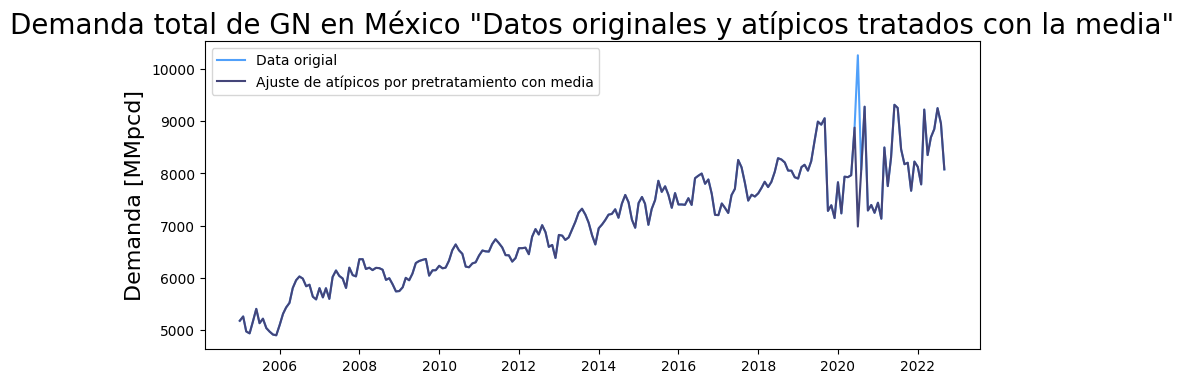

In [201]:
plt.figure(figsize=(10,4))
plt.plot(demanda_total_original_train_data, color='#50A0FA')
plt.plot(demanda_total_train_pretratamiento_media, color='#444579')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda total de GN en México "Datos originales y atípicos tratados con la media"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

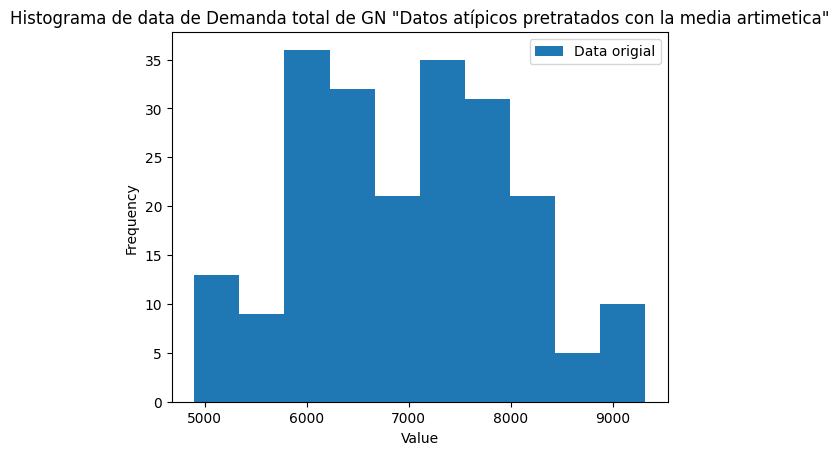

In [203]:
# Generate the histogram
plt.hist(demanda_total_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda total de GN "Datos atípicos pretratados con la media artimetica"')
# Display the plot
plt.show()

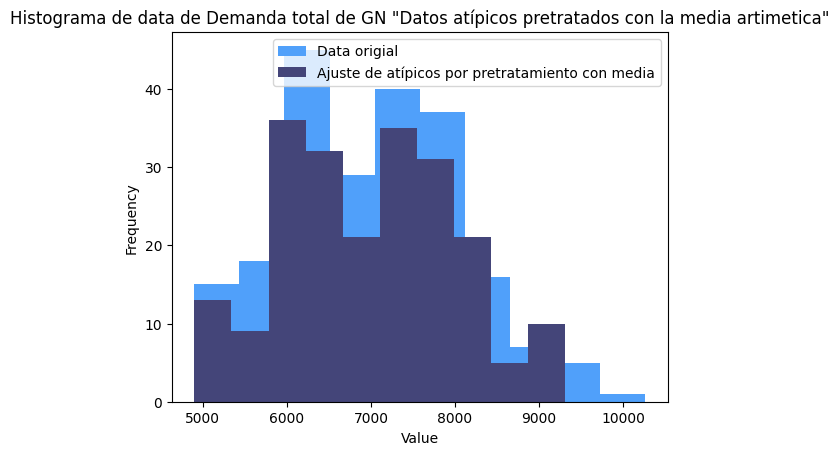

In [204]:
# Generate the histogram

plt.hist(demanda_total_original_train_data, bins=10, color='#50A0FA')
plt.hist(demanda_total_train_pretratamiento_media, bins=10, color='#444579')  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda total de GN "Datos atípicos pretratados con la media artimetica"')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
# Display the plot
plt.show()

In [205]:
demanda_total_train_pretratamiento_media.describe()

count     213.000000
mean     6982.484104
std      1019.652091
min      4897.946000
25%      6193.127000
50%      7014.876000
75%      7739.622000
max      9316.100000
Name: Demanded_Gas, dtype: float64

Evaluación de la dispersión de los datos mediante el cociente de media / desviación estandar

In [206]:

mean_demanda_total_train_pretratamiento_media = demanda_total_train_pretratamiento_media.describe().values[1]
mean_demanda_total_train_pretratamiento_media

6982.484103773585

In [207]:
std_demanda_total_train_pretratamiento_media = demanda_total_train_pretratamiento_media.describe().values[2]
std_demanda_total_train_pretratamiento_media

1019.6520907599005

In [208]:
mean_demanda_total_train_pretratamiento_media / std_demanda_total_train_pretratamiento_media

6.847908386643778

Recordando el valor del cociente para el caso de no tratamiento de atípicos

In [209]:
mean_demanda_total_original_train_data / st_demanda_total_original_train_data

array([6.70187879])

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda total de GN para el caso de pretratamiento con la media artimetica

In [210]:
import scipy.stats as stats

# Assuming demanda_total_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_total_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 3.1408605571235526
p-value: 0.20795568423111463


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

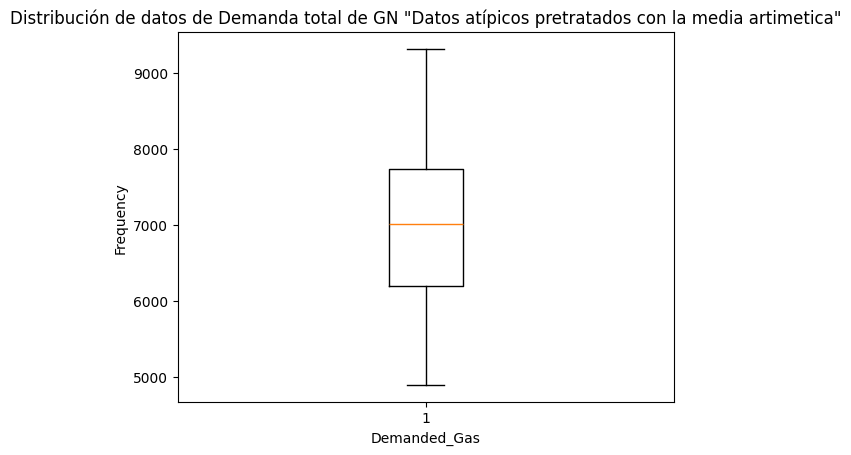

In [211]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_total_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda total de GN "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [212]:
n_input = n_input

data = demanda_total_train_pretratamiento_media
targets = data 

demanda_total_train_generator_pretratamiento_media = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [213]:
demanda_total_train_generator_pretratamiento_media[0]

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[5176.015, 5258.329, 4971.291, 4934.576, 5160.325, 5404.298,
         5129.745, 5215.837, 5035.884, 4968.442, 4911.473, 4897.946,
         5093.393, 5309.308, 5429.847, 5519.013, 5803.213, 5953.747,
         6025.457, 5984.675, 5837.793, 5867.907, 5637.33 , 5585.734]]),
 array([5801.336]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [214]:
print("Total number of samples in the original training data = ", len(demanda_total_train_pretratamiento_media)) 
print("Total number of samples in the demanda_total_train_generator = ", len(demanda_total_train_generator_pretratamiento_media))

Total number of samples in the original training data =  213
Total number of samples in the demanda_total_train_generator =  189


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU.  

In [215]:
seed_value=2024

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.random.set_seed(seed_value)



In [216]:
n_input = n_input
n_features = n_features

# define model
model_LSTM_total_pretratamiento_media = Sequential()
model_LSTM_total_pretratamiento_media.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_total_pretratamiento_media.add(Dense(1))
model_LSTM_total_pretratamiento_media.compile(optimizer='adam', loss='mse')

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [217]:
model_LSTM_total_pretratamiento_media.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_residencial_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [218]:
model_LSTM_total_pretratamiento_media.fit(demanda_total_train_generator_pretratamiento_media, epochs=12)

Epoch 1/12
 12/189 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 12648315.0000

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 22523216.0000
Epoch 2/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16995954.0000
Epoch 3/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 10644829.0000
Epoch 4/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 672394.0000
Epoch 5/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3468684.7500
Epoch 6/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11862857.0000
Epoch 7/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 542581.8125
Epoch 8/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 12996062.0000
Epoch 9/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3794725.7500
Epoch 10/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 327737.2500
Epoch 11/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1228838.8750
Epoch 12/12
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2680732.5000


Se grafica la perdida por epoch 

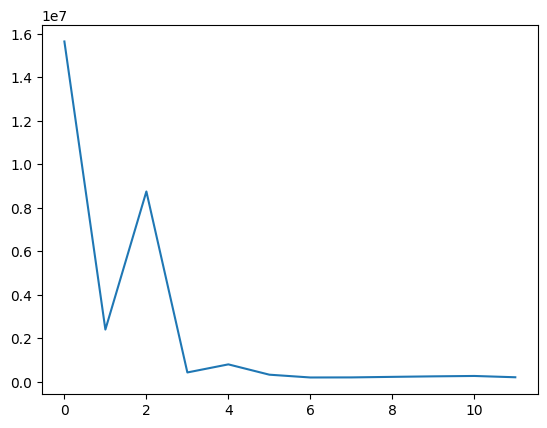

In [71]:
loss_per_epoch = model_LSTM_total_pretratamiento_media.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo LSTM previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [72]:
demanda_total_train_batch_pretratamiento_media = demanda_total_train_pretratamiento_media[-n_input:]


demanda_total_train_batch_pretratamiento_media

Date
2020-10-01    7290.056
2020-11-01    7395.813
2020-12-01    7245.577
2021-01-01    7438.808
2021-02-01    7132.971
2021-03-01    8497.784
2021-04-01    7757.688
2021-05-01    8305.158
2021-06-01    9316.100
2021-07-01    9255.921
2021-08-01    8464.915
2021-09-01    8176.696
2021-10-01    8204.940
2021-11-01    7668.455
2021-12-01    8227.622
2022-01-01    8126.255
2022-02-01    7790.445
2022-03-01    9224.254
2022-04-01    8352.515
2022-05-01    8692.273
2022-06-01    8851.433
2022-07-01    9252.496
2022-08-01    8957.842
2022-09-01    8078.561
Name: Demanded_Gas, dtype: float64

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [73]:
demanda_total_train_batch_pretratamiento_media_reshaped = demanda_total_train_batch_pretratamiento_media.values.reshape(1,n_input, n_features)
demanda_total_train_batch_pretratamiento_media_reshaped

array([[[7290.056],
        [7395.813],
        [7245.577],
        [7438.808],
        [7132.971],
        [8497.784],
        [7757.688],
        [8305.158],
        [9316.1  ],
        [9255.921],
        [8464.915],
        [8176.696],
        [8204.94 ],
        [7668.455],
        [8227.622],
        [8126.255],
        [7790.445],
        [9224.254],
        [8352.515],
        [8692.273],
        [8851.433],
        [9252.496],
        [8957.842],
        [8078.561]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [74]:
model_LSTM_total_pretratamiento_media.predict(demanda_total_train_batch_pretratamiento_media_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


array([[8044.584]], dtype=float32)

Y se compara el valor de forecast del modelo LSTM + pretratamiento media + normalizacion con los datos de test de la demanda de gas natural en sector residencial & autotrasnporte

In [75]:
demanda_total_original_test_data

,Demanded_Gas
Date,
2022-10-01,7751.912
2022-11-01,6921.741
2022-12-01,7436.708
2023-01-01,8286.752
2023-02-01,7728.131
2023-03-01,9143.067
2023-04-01,7817.064
2023-05-01,8193.326
2023-06-01,8913.460


Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [76]:
n_input = n_input
n_features = n_features

In [77]:
demanda_total_train_pretratamiento_media[-n_input:]

Date
2020-10-01    7290.056
2020-11-01    7395.813
2020-12-01    7245.577
2021-01-01    7438.808
2021-02-01    7132.971
2021-03-01    8497.784
2021-04-01    7757.688
2021-05-01    8305.158
2021-06-01    9316.100
2021-07-01    9255.921
2021-08-01    8464.915
2021-09-01    8176.696
2021-10-01    8204.940
2021-11-01    7668.455
2021-12-01    8227.622
2022-01-01    8126.255
2022-02-01    7790.445
2022-03-01    9224.254
2022-04-01    8352.515
2022-05-01    8692.273
2022-06-01    8851.433
2022-07-01    9252.496
2022-08-01    8957.842
2022-09-01    8078.561
Name: Demanded_Gas, dtype: float64

In [219]:
test_predictions_model_LSTM_total_pretratamiento_media  = []

first_eval_batch = demanda_total_train_pretratamiento_media[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_total_original_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_total_pretratamiento_media.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_total_pretratamiento_media.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [220]:
test_predictions_model_LSTM_total_pretratamiento_media

[array([5945.791], dtype=float32),
 array([11556.686], dtype=float32),
 array([11831.384], dtype=float32),
 array([8536.748], dtype=float32),
 array([7534.054], dtype=float32),
 array([11805.963], dtype=float32),
 array([12424.073], dtype=float32),
 array([5758.597], dtype=float32),
 array([8022.5], dtype=float32),
 array([13293.645], dtype=float32),
 array([6469.9736], dtype=float32),
 array([8554.832], dtype=float32)]

In [221]:
demanda_total_original_test_data['Demanded_Gas'].values

array([7751.912, 6921.741, 7436.708, 8286.752, 7728.131, 9143.067,
       7817.064, 8193.326, 8913.46 , 8031.15 , 7706.012, 6939.087])

Text(0, 0.5, 'Demanda [MMpcd]')

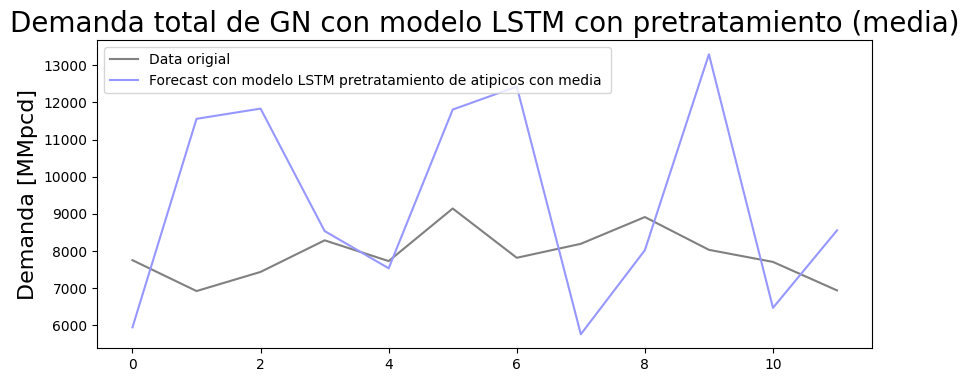

In [225]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_total_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_total_pretratamiento_media , color='#9697FF')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM pretratamiento de atipicos con media '))

plt.title('Demanda total de GN con modelo LSTM con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [223]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_total_pretratamiento_media = mean_absolute_percentage_error(demanda_total_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_total_pretratamiento_media)
RMSE_test_predictions_model_LSTM_total_pretratamiento_media = np.sqrt(mean_squared_error(demanda_total_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_total_pretratamiento_media))

print('MAPE:', MAPE_test_predictions_model_LSTM_total_pretratamiento_media)
print('RMSE:', RMSE_test_predictions_model_LSTM_total_pretratamiento_media)

MAPE: 0.32292168140655964
RMSE: 3041.760147149869


Se muestra la comparación del forecast de demanda residencial con modelo LSTM entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

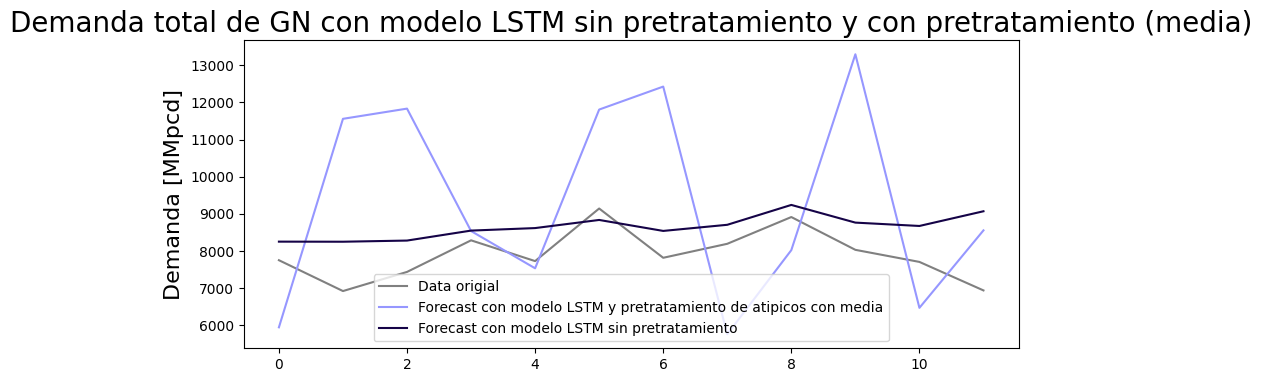

In [226]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_total_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_total_pretratamiento_media , color='#9697FF')
plt.plot(test_predictions_model_LSTM_total_original, color='#150347')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda total de GN con modelo LSTM sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Proceso para decidir el modelo ARIMA a aplicar en el caso de (pretratamiento de atípicos por la media)


Se verifica la estacionariedad de la data (pretratamiento de atípicos por la media) con ayuda de la prueba de Dickey-Fuller

In [84]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_residencial_pretratamiento_media_sin_diferenciar = adfuller(demanda_residencial_train_pretratamiento_media)

adf_test_residencial_pretratamiento_media_sin_diferenciar

(-1.4965790071305538,
 0.5352029712492087,
 14,
 198,
 {'1%': -3.4638151713286316,
  '5%': -2.876250632135043,
  '10%': -2.574611347821651},
 2824.300300662334)

In [85]:
print(f"The ADF statistic value f is: {adf_test_residencial_pretratamiento_media_sin_diferenciar[0]}")

print(f"The ADF p value p is: {adf_test_residencial_pretratamiento_media_sin_diferenciar[1]}")

if adf_test_residencial_pretratamiento_media_sin_diferenciar[0] < adf_test_residencial_pretratamiento_media_sin_diferenciar[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -1.4965790071305538
The ADF p value p is: 0.5352029712492087
Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad


Se procede a hacer la primer diferencia para lograr estacionariedad

In [86]:
demanda_residencial_pretratamiento_media_diff1 = demanda_residencial_train_pretratamiento_media.diff()
demanda_residencial_pretratamiento_media_diff1

Date
2005-01-01        NaN
2005-02-01     82.314
2005-03-01   -287.038
2005-04-01    -36.715
2005-05-01    225.749
               ...   
2022-05-01    339.758
2022-06-01    159.160
2022-07-01    401.063
2022-08-01   -294.654
2022-09-01   -879.281
Name: Demanded_Gas, Length: 213, dtype: float64

Se verifica la estacionariedad de la data DIFERENCIA1 (pretratamiento de atípicos por la media) con ayuda de la prueba de Dickey-Fulley

In [87]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_residencial_pretratamiento_media_diff1 = adfuller(demanda_residencial_pretratamiento_media_diff1.dropna())

adf_test_residencial_pretratamiento_media_diff1

(-4.4598629990958445,
 0.00023221953438588925,
 13,
 198,
 {'1%': -3.4638151713286316,
  '5%': -2.876250632135043,
  '10%': -2.574611347821651},
 2809.1650951487673)

In [88]:
print(f"The ADF statistic value f is: {adf_test_residencial_pretratamiento_media_diff1[0]}")

print(f"The ADF p value p is: {adf_test_residencial_pretratamiento_media_diff1[1]}")

if adf_test_residencial_pretratamiento_media_diff1[0] < adf_test_residencial_pretratamiento_media_diff1[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -4.4598629990958445
The ADF p value p is: 0.00023221953438588925
Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad


Se realizan las gráficas ACF & PACF para determinar el tipo de modelo ARIMA a implementar

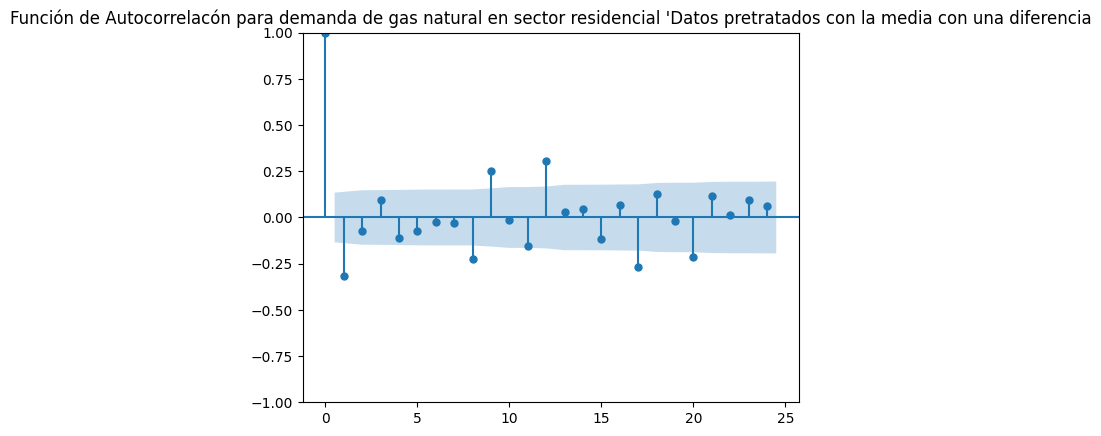

In [89]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_acf(demanda_residencial_pretratamiento_media_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón para demanda de gas natural en sector residencial 'Datos pretratados con la media con una diferencia")

# Show the plot
plt.show()

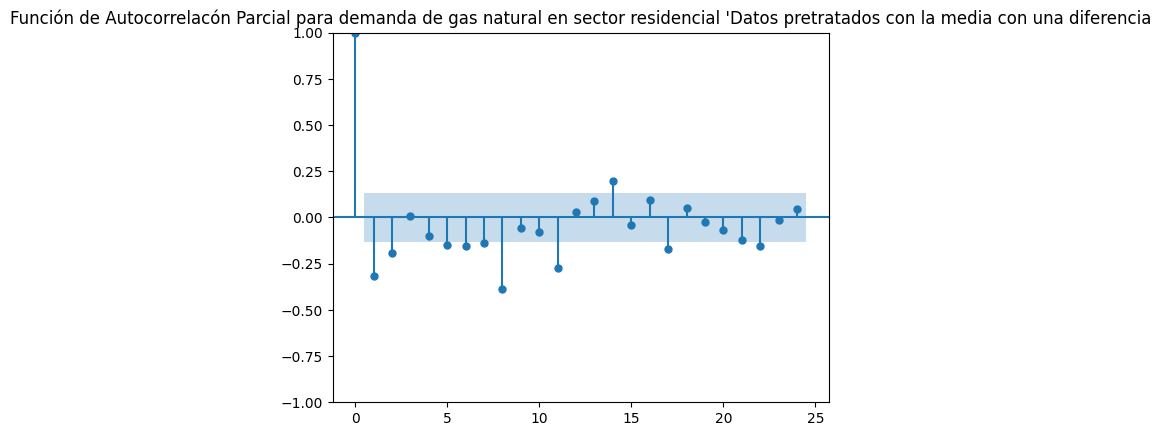

In [90]:

import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_pacf(demanda_residencial_pretratamiento_media_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón Parcial para demanda de gas natural en sector residencial 'Datos pretratados con la media con una diferencia")

# Show the plot
plt.show()

Apliquemos un modelo ARIMA a nuestra data de Demanda de gas natural en sector residencial 'Datos atipicos con tratamiento media'

In [91]:
##Create the model
model_ARIMA_residencial_tratamiento_media = ARIMA (demanda_residencial_train_pretratamiento_media, order=(4,1,3))

##Fit the model
start = time()
model_ARIMA_residencial_tratamiento_media_fit = model_ARIMA_residencial_tratamiento_media.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_residencial_tratamiento_media_fit.summary())

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\sta

Model fitting time 2.2285633087158203
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1531.555
Date:                Mon, 13 May 2024   AIC                           3079.110
Time:                        14:09:45   BIC                           3105.963
Sample:                    01-01-2005   HQIC                          3089.963
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1115      0.082     -1.362      0.173      -0.272       0.049
ar.L2         -0.6115      0.090     -6.828      0.000      -0.787      -0.436
ar.L3         

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [92]:
##get prediction start and end dates 
pred_model_ARIMA_residencial_start_date = demanda_residencial_original_test_data.index[0]
pred_model_ARIMA_residencial_end_date = demanda_residencial_original_test_data.index[-1]

In [93]:
##get the predictors and residuals 
predictions_model_ARIMA_residencial_tratamiento_media = model_ARIMA_residencial_tratamiento_media_fit.predict(start=pred_model_ARIMA_residencial_start_date, end= pred_model_ARIMA_residencial_end_date)
print(predictions_model_ARIMA_residencial_tratamiento_media)

2022-10-01    8370.326202
2022-11-01    8393.239151
2022-12-01    8344.126357
2023-01-01    8494.096722
2023-02-01    8507.882611
2023-03-01    8392.110319
2023-04-01    8464.700510
2023-05-01    8528.534107
2023-06-01    8425.250315
2023-07-01    8433.754145
2023-08-01    8521.850458
2023-09-01    8458.924251
Freq: MS, Name: predicted_mean, dtype: float64


In [94]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_residencial_tratamiento_media = mean_absolute_percentage_error(demanda_residencial_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_residencial_tratamiento_media)
RMSE_predictions_model_ARIMA_residencial_tratamiento_media= np.sqrt(mean_squared_error(demanda_residencial_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_residencial_tratamiento_media))

print('MAPE:', MAPE_predictions_model_ARIMA_residencial_tratamiento_media)
print('RMSE:', RMSE_predictions_model_ARIMA_residencial_tratamiento_media)

MAPE: 0.0979998478631231
RMSE: 841.3196644128301


Text(0, 0.5, 'Demanda [MMpcd]')

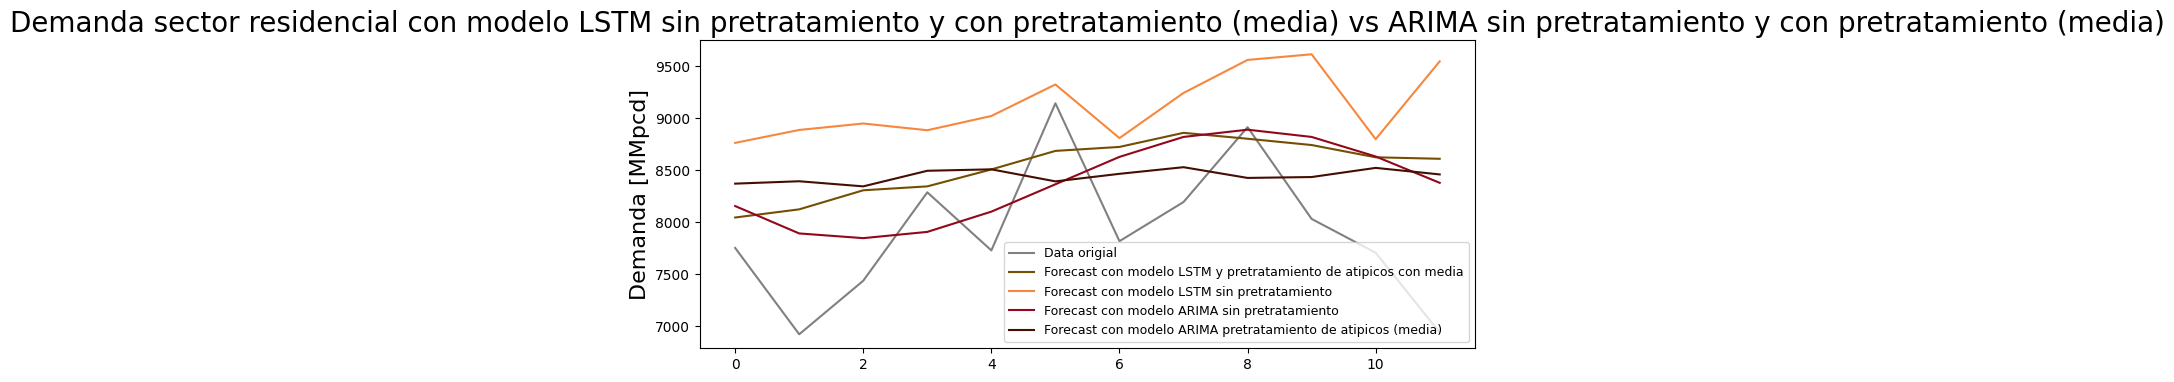

In [95]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))


plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_media , color='#744E03')
plt.plot(test_predictions_model_LSTM_residencial_original, color='#F8873E')

plt.plot(predictions_model_ARIMA_residencial_original.values, color='#92071C')

plt.plot(predictions_model_ARIMA_residencial_tratamiento_media.values,color='#460E01')

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media', 'Forecast con modelo LSTM sin pretratamiento', 'Forecast con modelo ARIMA sin pretratamiento ', 'Forecast con modelo ARIMA pretratamiento de atipicos (media)' ), fontsize=9)

plt.title('Demanda sector residencial con modelo LSTM sin pretratamiento y con pretratamiento (media) vs ARIMA sin pretratamiento y con pretratamiento (media)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [96]:
MAPE_predictions_model_ARIMA_residencial_tratamiento_media: 0.13994500811231925
RMSE_predictions_model_ARIMA_residencial_tratamiento_media: 655.5176263602883
MAPE_predictions_model_LSTM_residencial_pretratamiento_media: 0.1138521851839455
RMSE_predictions_model_LSTM_residencial_pretratamiento_media: 582.2575418499564

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [97]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [98]:
demanda_residencial_original_train_para_tratamiento2 = demanda_residencial_original_train_data.copy()
demanda_residencial_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,5176.015
2005-02-01,5258.329
2005-03-01,4971.291
2005-04-01,4934.576
2005-05-01,5160.325
...,...
2022-05-01,8692.273
2022-06-01,8851.433
2022-07-01,9252.496


In [99]:
demanda_residencial_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_residencial_original_train_para_tratamiento2['Demanded_Gas'])
demanda_residencial_train_pretratamiento_mediana

Date
2005-01-01    5176.015
2005-02-01    5258.329
2005-03-01    4971.291
2005-04-01    4934.576
2005-05-01    5160.325
                ...   
2022-05-01    8692.273
2022-06-01    8851.433
2022-07-01    9252.496
2022-08-01    8957.842
2022-09-01    8078.561
Name: Demanded_Gas, Length: 213, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

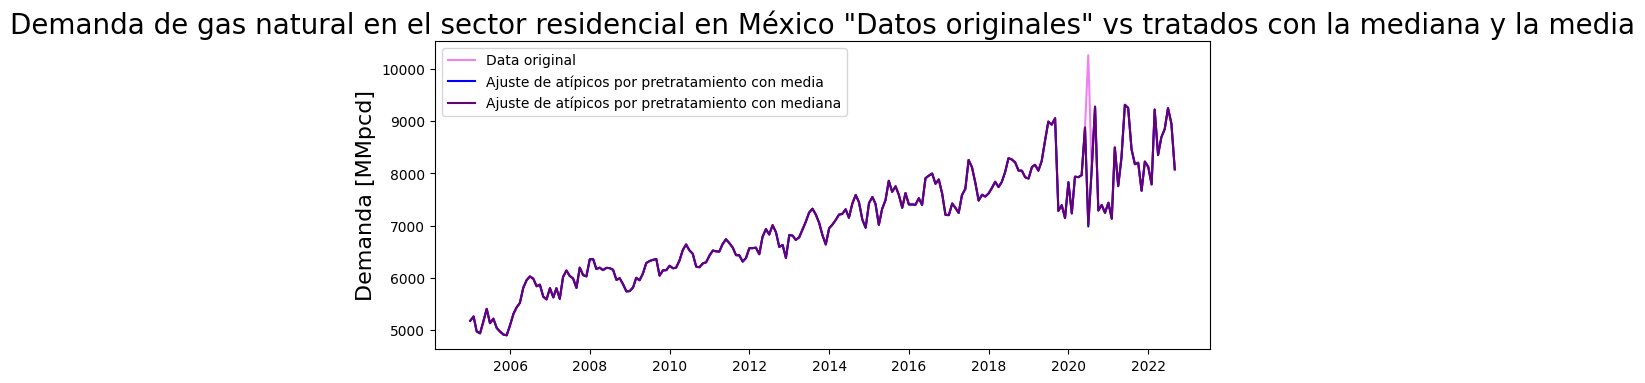

In [100]:
plt.figure(figsize=(10,4))

plt.plot(demanda_residencial_original_train_data, color='violet')
plt.plot(demanda_residencial_train_pretratamiento_media,color='blue')

plt.plot(demanda_residencial_train_pretratamiento_mediana, color= '#660374')


plt.legend(('Data original', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con mediana'))
plt.title('Demanda de gas natural en el sector residencial en México "Datos originales" vs tratados con la mediana y la media', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de mediana de Demanda en sector residencial en sus componentes de Tendencia, Estacionalidad y Residual

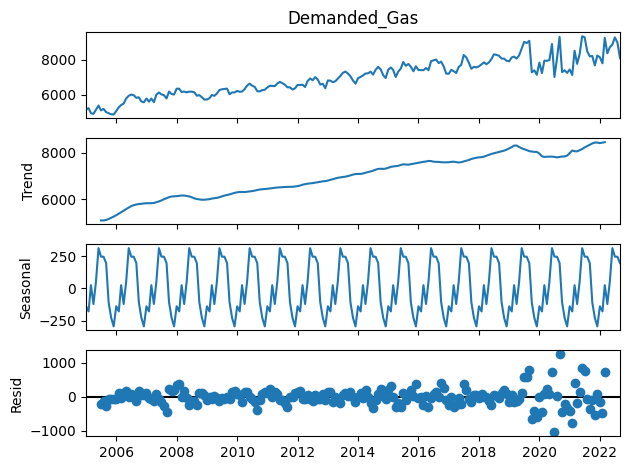

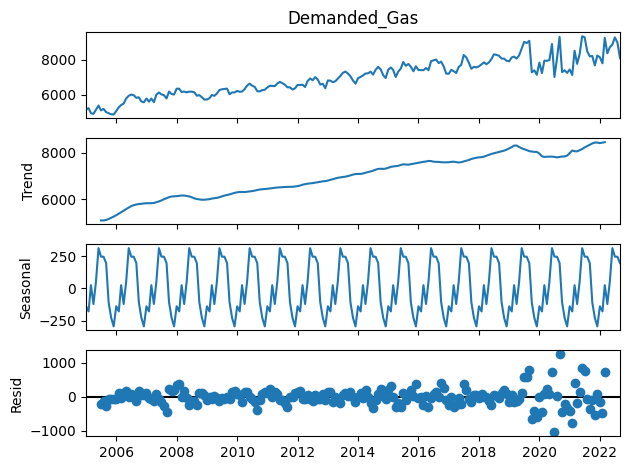

In [101]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_residencial_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_residencial_train_pretratamiento_mediana)
demanda_residencial_train_pretratamiento_mediana_seasonal_decomposition.plot()


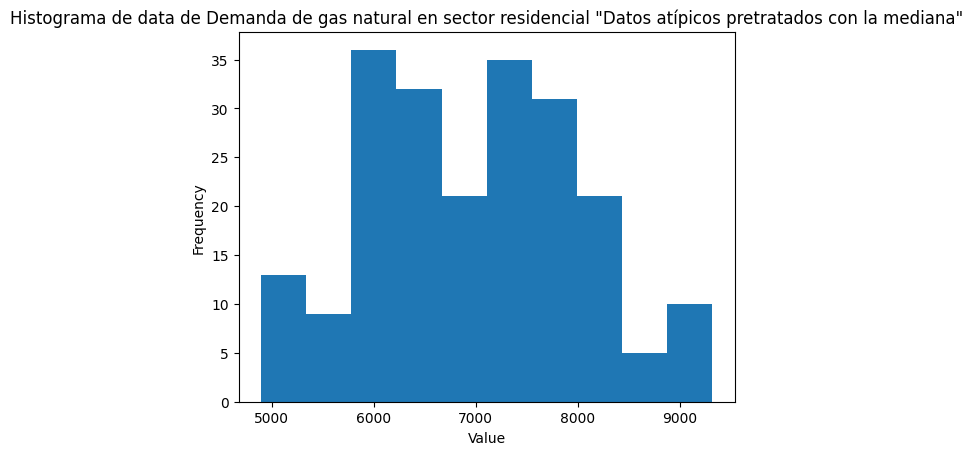

In [102]:
# Generate the histogram
plt.hist(demanda_residencial_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector residencial "Datos atípicos pretratados con la mediana"')
# Display the plot
plt.show()

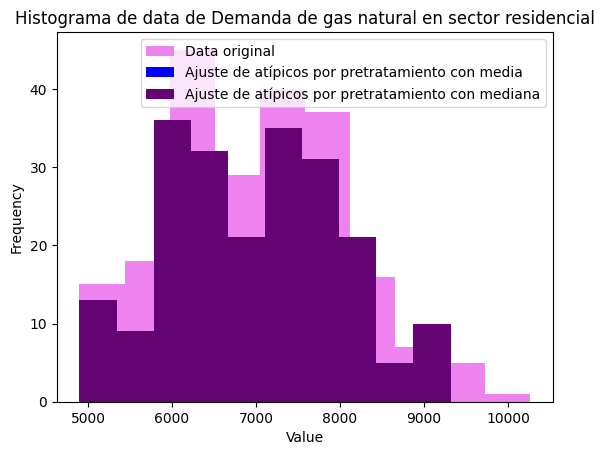

In [103]:
# Generate the histogram

plt.hist(demanda_residencial_original_train_data, bins=10, color= 'violet')

plt.hist(demanda_residencial_train_pretratamiento_media, bins=10, color= 'blue')  # Adjust the number of bins as per your data

plt.hist(demanda_residencial_train_pretratamiento_mediana, bins=10, color= '#660374')  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector residencial')

plt.legend(('Data original', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con mediana'))

# Display the plot
plt.show()

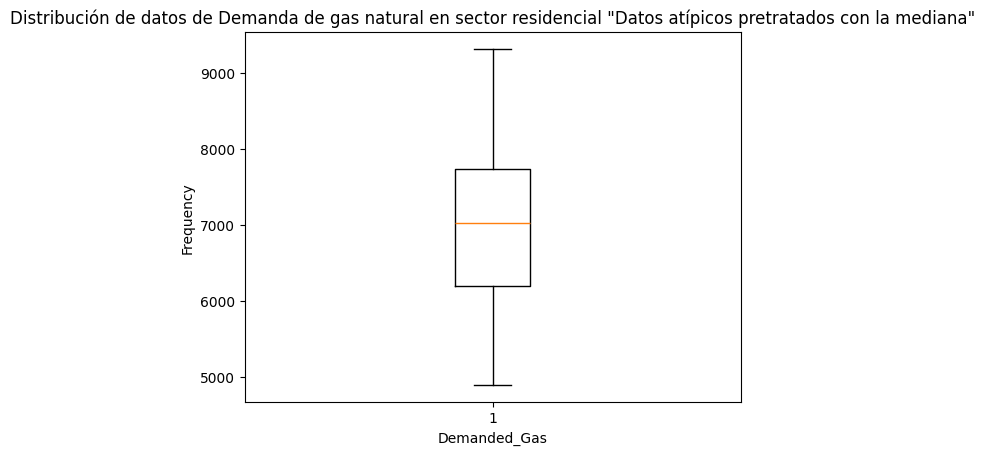

In [104]:
# Create a boxplot of the Demanded_Gas column

plt.boxplot(demanda_residencial_train_pretratamiento_mediana)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector residencial "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

In [105]:
demanda_residencial_train_pretratamiento_mediana.describe()

count     213.000000
mean     6982.654758
std      1019.655133
min      4897.946000
25%      6193.127000
50%      7018.833500
75%      7739.622000
max      9316.100000
Name: Demanded_Gas, dtype: float64

Evaluación de la dispersión de los datos mediante el cociente de media / desviación estandar

In [106]:
mean_demanda_residencial_train_pretratamiento_mediana = demanda_residencial_train_pretratamiento_mediana.describe().values[1]
mean_demanda_residencial_train_pretratamiento_mediana

6982.654758215963

In [107]:
std_demanda_residencial_train_pretratamiento_mediana = demanda_residencial_train_pretratamiento_mediana.describe().values[2]
std_demanda_residencial_train_pretratamiento_mediana

1019.6551325703118

In [108]:
mean_demanda_residencial_train_pretratamiento_mediana / std_demanda_residencial_train_pretratamiento_mediana

6.848055322993693

Recordando el valor del cociente para el caso de no tratamiento de atípicos y de tratamiento con la media

In [109]:
mean_demanda_residencial_original_train_data / st_demanda_residencial_original_train_data

array([6.70187879])

In [110]:
mean_demanda_residencial_train_pretratamiento_media / std_demanda_residencial_train_pretratamiento_media

6.847908386643778

In [111]:
import scipy.stats as stats

# Assuming demanda_residencial_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_residencial_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 3.1385635578408744
p-value: 0.2081946584645109


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [112]:
n_input = n_input 

data = demanda_residencial_train_pretratamiento_mediana
targets = data 

demanda_residencial_train_generator_pretratamiento_mediana = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_residencial_train_generator_pretratamiento_mediana[0]

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\legacy\preprocessing\sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


(array([[5176.015, 5258.329, 4971.291, 4934.576, 5160.325, 5404.298,
         5129.745, 5215.837, 5035.884, 4968.442, 4911.473, 4897.946,
         5093.393, 5309.308, 5429.847, 5519.013, 5803.213, 5953.747,
         6025.457, 5984.675, 5837.793, 5867.907, 5637.33 , 5585.734]]),
 array([5801.336]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [113]:
print("Total number of samples in the original training data = ", len(demanda_residencial_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_residencial_scaled_train_generator = ", len(demanda_residencial_train_generator_pretratamiento_mediana))

Total number of samples in the original training data =  213
Total number of samples in the demanda_residencial_scaled_train_generator =  189


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector residencial con pretratamiento de mediana 

In [114]:
n_input = n_input
n_features = n_features

# define model
model_LSTM_residencial_pretrataminto_mediana = Sequential()

model_LSTM_residencial_pretrataminto_mediana.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_residencial_pretrataminto_mediana.add(Dense(1))
model_LSTM_residencial_pretrataminto_mediana.compile(optimizer='adam', loss='mse')

model_LSTM_residencial_pretrataminto_mediana.summary()

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

Se entrena el modelo 

In [115]:
model_LSTM_residencial_pretrataminto_mediana.fit(demanda_residencial_train_generator_pretratamiento_mediana, epochs=15)

Epoch 1/15


 29/189 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 104025208.0000

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 62822384.0000
Epoch 2/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1513053.5000
Epoch 3/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 213626.1094
Epoch 4/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 219260.0000
Epoch 5/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 183706.2656
Epoch 6/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 239298.5781
Epoch 7/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 210020.5625
Epoch 8/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 183183.5938
Epoch 9/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 211752.2656
Epoch 10/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 258700.8125
Epoch 11/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 159024.1406
Epoch 12/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 303693.9375
Epoch 13/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 255261.6094
Epoch 14/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 248005.

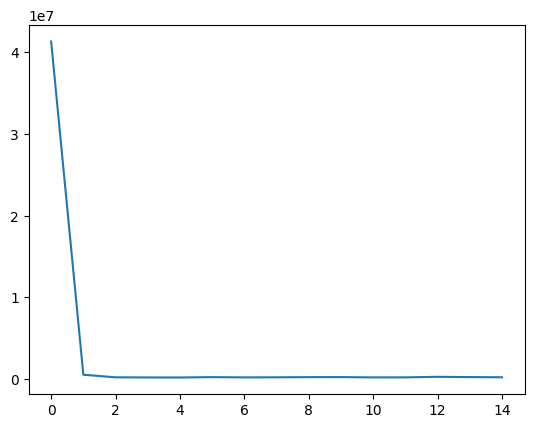

In [116]:
loss_per_epoch = model_LSTM_residencial_pretrataminto_mediana.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [117]:
demanda_residencial_train_pretratamiento_mediana

Date
2005-01-01    5176.015
2005-02-01    5258.329
2005-03-01    4971.291
2005-04-01    4934.576
2005-05-01    5160.325
                ...   
2022-05-01    8692.273
2022-06-01    8851.433
2022-07-01    9252.496
2022-08-01    8957.842
2022-09-01    8078.561
Name: Demanded_Gas, Length: 213, dtype: float64

In [118]:
demanda_residencial_train_batch_pretratamiento_mediana = demanda_residencial_train_pretratamiento_mediana[-n_input:]


demanda_residencial_train_batch_pretratamiento_mediana

Date
2020-10-01    7290.056
2020-11-01    7395.813
2020-12-01    7245.577
2021-01-01    7438.808
2021-02-01    7132.971
2021-03-01    8497.784
2021-04-01    7757.688
2021-05-01    8305.158
2021-06-01    9316.100
2021-07-01    9255.921
2021-08-01    8464.915
2021-09-01    8176.696
2021-10-01    8204.940
2021-11-01    7668.455
2021-12-01    8227.622
2022-01-01    8126.255
2022-02-01    7790.445
2022-03-01    9224.254
2022-04-01    8352.515
2022-05-01    8692.273
2022-06-01    8851.433
2022-07-01    9252.496
2022-08-01    8957.842
2022-09-01    8078.561
Name: Demanded_Gas, dtype: float64

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [119]:
demanda_residencial_train_batch_pretratamiento_mediana_reshaped = demanda_residencial_train_batch_pretratamiento_mediana.values.reshape(1,n_input, n_features)
demanda_residencial_train_batch_pretratamiento_mediana_reshaped

array([[[7290.056],
        [7395.813],
        [7245.577],
        [7438.808],
        [7132.971],
        [8497.784],
        [7757.688],
        [8305.158],
        [9316.1  ],
        [9255.921],
        [8464.915],
        [8176.696],
        [8204.94 ],
        [7668.455],
        [8227.622],
        [8126.255],
        [7790.445],
        [9224.254],
        [8352.515],
        [8692.273],
        [8851.433],
        [9252.496],
        [8957.842],
        [8078.561]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [120]:
model_LSTM_residencial_pretrataminto_mediana.predict(demanda_residencial_train_batch_pretratamiento_mediana_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


array([[7901.2524]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [121]:
n_input = n_input
n_features = n_features

In [122]:
test_predictions_model_LSTM_residencial_pretratamiento_mediana  = []

first_eval_batch = demanda_residencial_train_pretratamiento_mediana[-n_input:].values
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_residencial_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_residencial_pretrataminto_mediana.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_residencial_pretratamiento_mediana.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [123]:
test_predictions_model_LSTM_residencial_pretratamiento_mediana

[array([7901.2524], dtype=float32),
 array([8047.4487], dtype=float32),
 array([8208.124], dtype=float32),
 array([8449.385], dtype=float32),
 array([8495.05], dtype=float32),
 array([8938.924], dtype=float32),
 array([9017.132], dtype=float32),
 array([9187.305], dtype=float32),
 array([9184.532], dtype=float32),
 array([9302.448], dtype=float32),
 array([8735.419], dtype=float32),
 array([8624.248], dtype=float32)]

Text(0, 0.5, 'Demanda [MMpcd]')

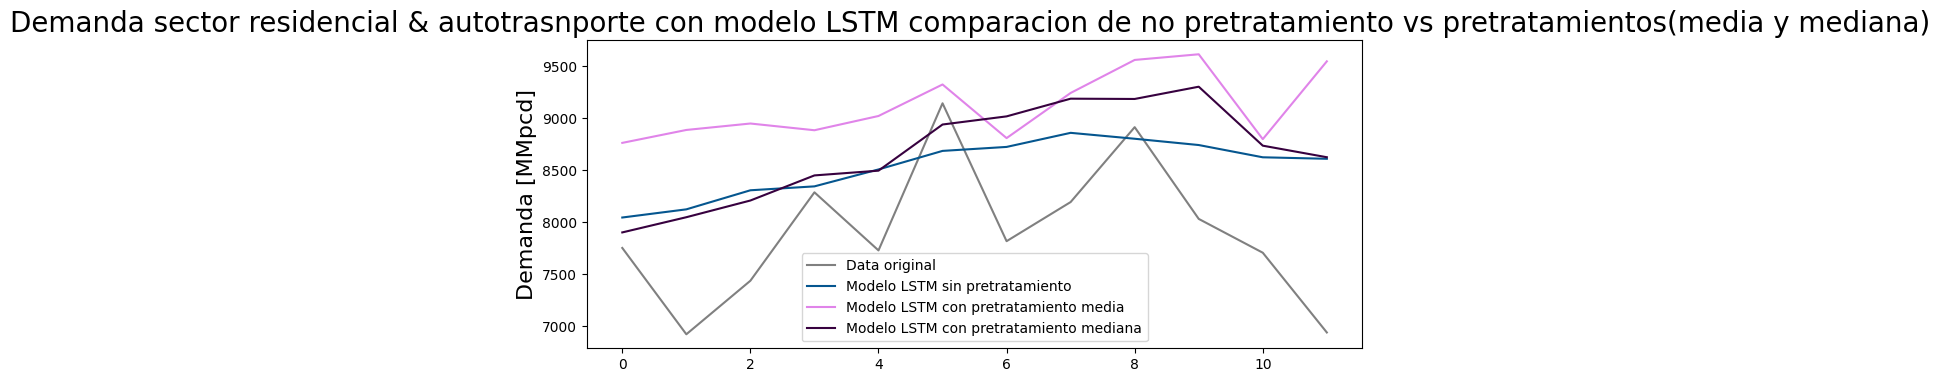

In [124]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')

plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_media , color='#05568F')
plt.plot(test_predictions_model_LSTM_residencial_original, color='#E084E9')
plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_mediana, color='#37013F' )


plt.legend(('Data original', 'Modelo LSTM sin pretratamiento', 'Modelo LSTM con pretratamiento media', 'Modelo LSTM con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector residencial & autotrasnporte con modelo LSTM comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [125]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_residencial_pretratamiento_mediana = mean_absolute_percentage_error(demanda_residencial_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_residencial_pretratamiento_mediana)
RMSE_test_predictions_model_LSTM_residencial_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_residencial_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_residencial_pretratamiento_mediana))

print('MAPE:', MAPE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)

MAPE: 0.10556646646616717
RMSE: 938.002028905719



Proceso para decidir el modelo ARIMA a aplicar en el caso de (pretratamiento de atípicos por la mediana)


Se verifica la estacionariedad de la data (pretratamiento de atípicos por la mediana) con ayuda de la prueba de Dickey-Fuller

In [126]:

import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_residencial_pretratamiento_mediana_sin_diferenciar = adfuller(demanda_residencial_train_pretratamiento_mediana)

adf_test_residencial_pretratamiento_mediana_sin_diferenciar

(-1.4989611604033575,
 0.5340251752674879,
 14,
 198,
 {'1%': -3.4638151713286316,
  '5%': -2.876250632135043,
  '10%': -2.574611347821651},
 2822.519361070311)

In [127]:
print(f"The ADF statistic value f is: {adf_test_residencial_pretratamiento_mediana_sin_diferenciar[0]}")

print(f"The ADF p value p is: {adf_test_residencial_pretratamiento_mediana_sin_diferenciar[1]}")

if adf_test_residencial_pretratamiento_mediana_sin_diferenciar[0] < adf_test_residencial_pretratamiento_mediana_sin_diferenciar[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -1.4989611604033575
The ADF p value p is: 0.5340251752674879
Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad



Se procede a hacer la primer diferencia para lograr estacionariedad

In [128]:
demanda_residencial_pretratamiento_mediana_diff1 = demanda_residencial_train_pretratamiento_mediana.diff()
demanda_residencial_pretratamiento_mediana_diff1

Date
2005-01-01        NaN
2005-02-01     82.314
2005-03-01   -287.038
2005-04-01    -36.715
2005-05-01    225.749
               ...   
2022-05-01    339.758
2022-06-01    159.160
2022-07-01    401.063
2022-08-01   -294.654
2022-09-01   -879.281
Name: Demanded_Gas, Length: 213, dtype: float64


Se verifica la estacionariedad de la data DIFERENCIA1 (pretratamiento de atípicos por la mediana) con ayuda de la prueba de Dickey-Fuller

In [129]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_test_residencial_pretratamiento_mediana_diff1 = adfuller(demanda_residencial_pretratamiento_mediana_diff1.dropna())

adf_test_residencial_pretratamiento_mediana_diff1

(-4.445865830178549,
 0.00024600656250349604,
 13,
 198,
 {'1%': -3.4638151713286316,
  '5%': -2.876250632135043,
  '10%': -2.574611347821651},
 2807.376140735816)

In [130]:
print(f"The ADF statistic value f is: {adf_test_residencial_pretratamiento_mediana_diff1[0]}")

print(f"The ADF p value p is: {adf_test_residencial_pretratamiento_mediana_diff1[1]}")

if adf_test_residencial_pretratamiento_mediana_diff1[0] < adf_test_residencial_pretratamiento_mediana_diff1[4]['5%']:
    print("Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad")
else:
    print("Se acepta H0: que indica la existencia de raiz unitaria y por lo tanto de NO estacionariedad")

The ADF statistic value f is: -4.445865830178549
The ADF p value p is: 0.00024600656250349604
Se rechaza H0: que indica la existencia de raiz unitaria y por lo tanto de SI estacionariedad



Se realizan las gráficas ACF & PACF para determinar el tipo de modelo ARIMA a implementar

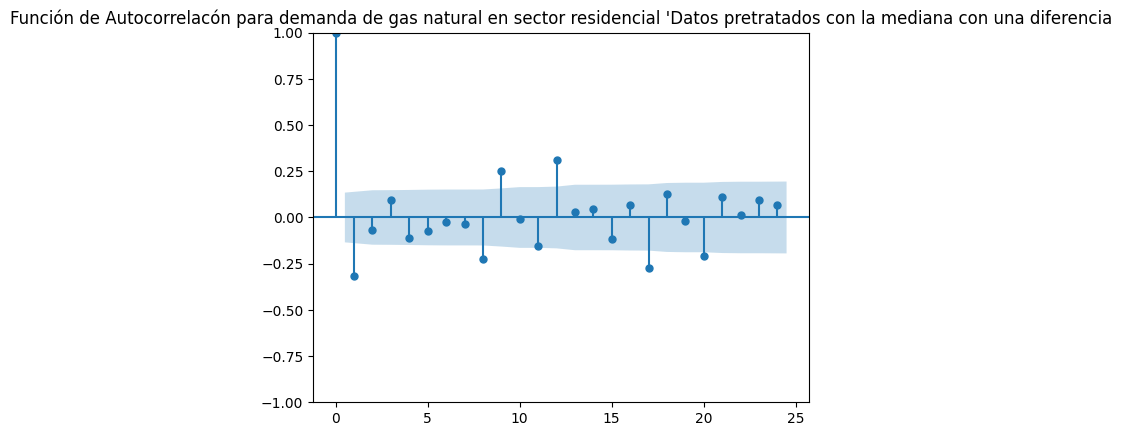

In [131]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_acf(demanda_residencial_pretratamiento_mediana_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón para demanda de gas natural en sector residencial 'Datos pretratados con la mediana con una diferencia")

# Show the plot
plt.show()

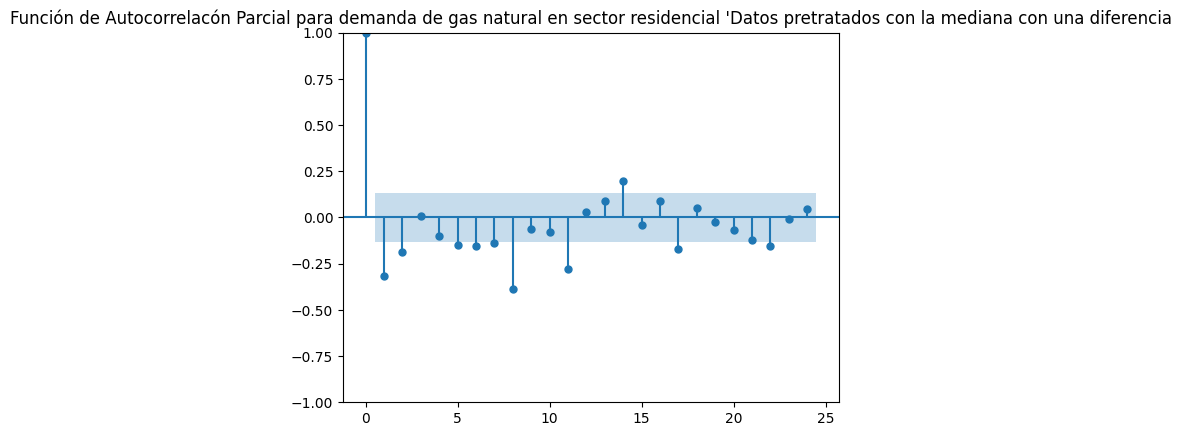

In [132]:
import statsmodels.graphics.tsaplots as tsaplot
# Create the Matplotlib axes object
fig, ax = plt.subplots()

# Plot the ACF
tsaplot.plot_pacf(demanda_residencial_pretratamiento_mediana_diff1.dropna(), ax=ax)

# Set the title
ax.set_title("Función de Autocorrelacón Parcial para demanda de gas natural en sector residencial 'Datos pretratados con la mediana con una diferencia")

# Show the plot
plt.show()

Modelo ARIMA para el caso del pretratamiento de datos con la mediana 

In [133]:
##Create the model
model_ARIMA_residencial_tratamiento_mediana = ARIMA (demanda_residencial_train_pretratamiento_mediana, order=(3,1,3))

##Fit the model
start = time()
model_ARIMA_residencial_tratamiento_mediana_fit = model_ARIMA_residencial_tratamiento_mediana.fit()
end = time()
print('Model fitting time', end-start)

##Summary of the model 
print(model_ARIMA_residencial_tratamiento_mediana_fit.summary())

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\tsa\sta

Model fitting time 2.0244688987731934
                               SARIMAX Results                                
Dep. Variable:           Demanded_Gas   No. Observations:                  213
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1531.136
Date:                Mon, 13 May 2024   AIC                           3076.272
Time:                        14:10:15   BIC                           3099.768
Sample:                    01-01-2005   HQIC                          3085.769
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1176      0.081     -1.449      0.147      -0.277       0.042
ar.L2         -0.5831      0.065     -8.940      0.000      -0.711      -0.455
ar.L3         

c:\Users\sergi\OneDrive\Documentos\MIS_UNAM\MIS_Tesis_Full_follow_HP-I3\MIS_Tesis_GitHub\MIS_Tesis_Venv1\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [134]:
##get prediction start and end dates 
pred_model_ARIMA_residencial_start_date = demanda_residencial_original_test_data.index[0]
pred_model_ARIMA_residencial_end_date = demanda_residencial_original_test_data.index[-1]

In [135]:
##get the predictors and residuals 
predictions_model_ARIMA_residencial_tratamiento_mediana = model_ARIMA_residencial_tratamiento_mediana_fit.predict(start=pred_model_ARIMA_residencial_start_date, end= pred_model_ARIMA_residencial_end_date)
print(predictions_model_ARIMA_residencial_tratamiento_mediana)

2022-10-01    8382.755595
2022-11-01    8382.259338
2022-12-01    8333.057206
2023-01-01    8479.274067
2023-02-01    8490.537083
2023-03-01    8381.290086
2023-04-01    8454.932945
2023-05-01    8515.159522
2023-06-01    8414.807481
2023-07-01    8425.420393
2023-08-01    8510.430860
2023-09-01    8448.012893
Freq: MS, Name: predicted_mean, dtype: float64


In [136]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana = mean_absolute_percentage_error(demanda_residencial_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_residencial_tratamiento_mediana)
RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana= np.sqrt(mean_squared_error(demanda_residencial_original_test_data['Demanded_Gas'].values, predictions_model_ARIMA_residencial_tratamiento_mediana))

print('MAPE:', MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana)
print('RMSE:', RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana)

MAPE: 0.09715622905453679
RMSE: 835.2472359583115


Text(0, 0.5, 'Demanda [MMpcd]')

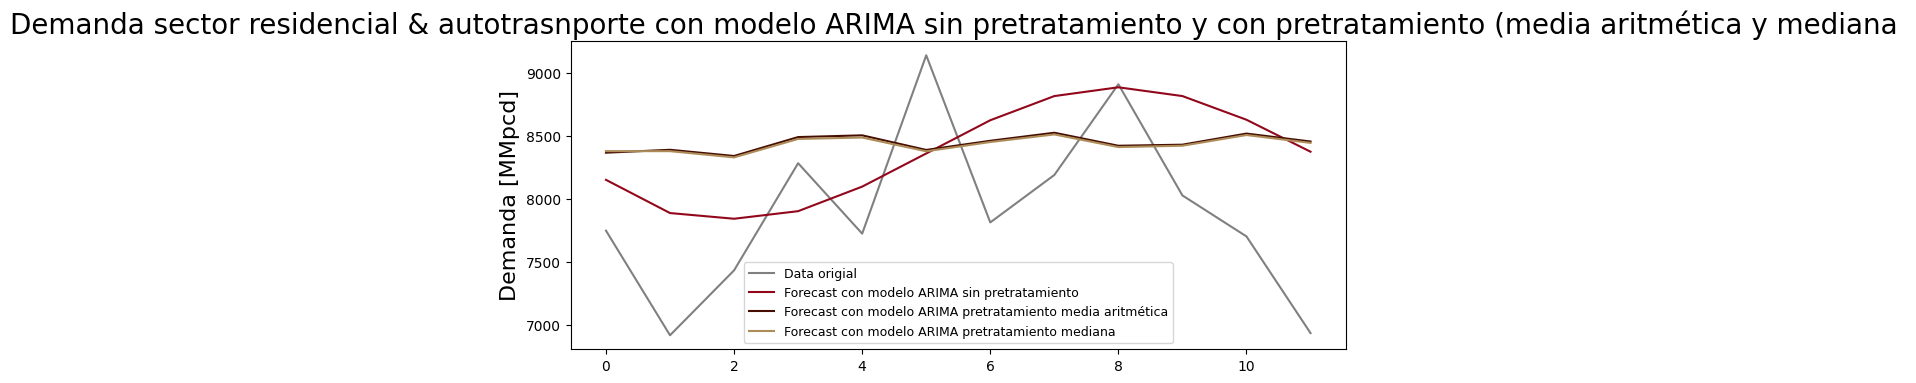

In [137]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='gray')


plt.plot(predictions_model_ARIMA_residencial_original.values, color='#92071C')
plt.plot(predictions_model_ARIMA_residencial_tratamiento_media.values,color='#460E01')

plt.plot(predictions_model_ARIMA_residencial_tratamiento_mediana.values, color='#AD8C59')



plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial','Forecast con modelo ARIMA sin pretratamiento','Forecast con modelo ARIMA pretratamiento media aritmética', 'Forecast con modelo ARIMA pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector residencial & autotrasnporte con modelo ARIMA sin pretratamiento y con pretratamiento (media aritmética y mediana ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Text(0, 0.5, 'Demanda [MMpcd]')

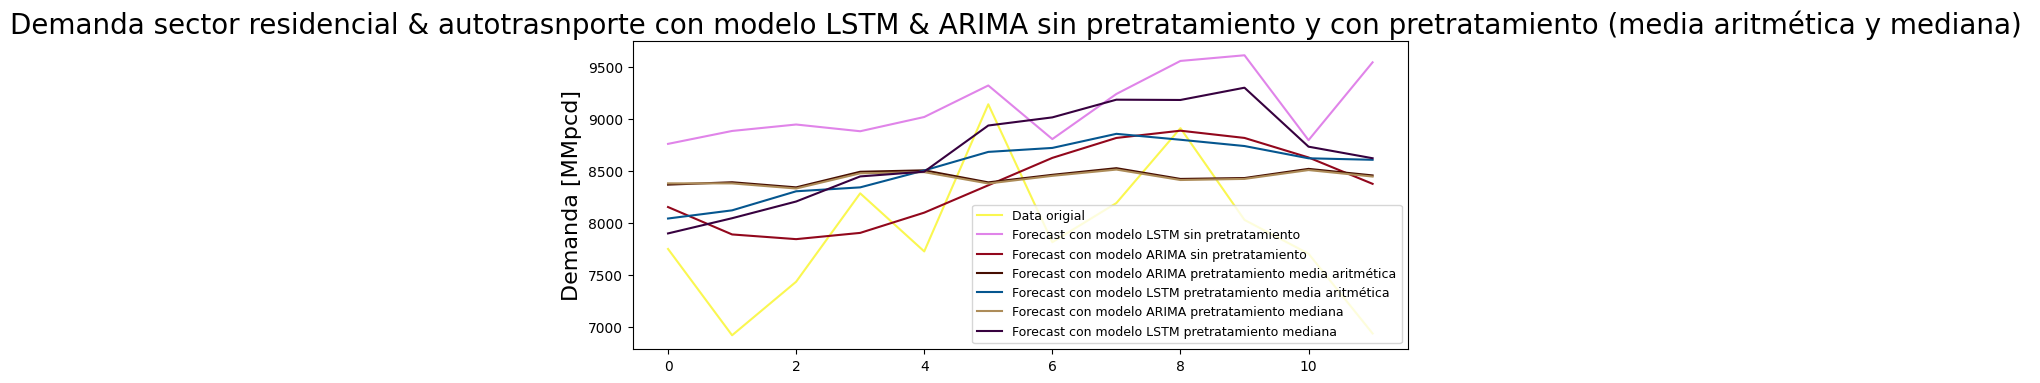

In [138]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_residencial_original_test_data['Demanded_Gas'].values, color='#FAF750')


plt.plot(test_predictions_model_LSTM_residencial_original, color='#E084E9')
plt.plot(predictions_model_ARIMA_residencial_original.values, color='#92071C')

plt.plot(predictions_model_ARIMA_residencial_tratamiento_media.values,color='#460E01')
plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_media , color='#05568F')


plt.plot(predictions_model_ARIMA_residencial_tratamiento_mediana.values, color='#AD8C59')
plt.plot(test_predictions_model_LSTM_residencial_pretratamiento_mediana, color='#37013F' )




plt.legend(('Data', 'Predictions'), fontsize=16)

plt.legend(('Data origial', 'Forecast con modelo LSTM sin pretratamiento','Forecast con modelo ARIMA sin pretratamiento', 'Forecast con modelo ARIMA pretratamiento media aritmética' , 'Forecast con modelo LSTM pretratamiento media aritmética ', 'Forecast con modelo ARIMA pretratamiento mediana' , 'Forecast con modelo LSTM pretratamiento mediana'), fontsize=9)

plt.title('Demanda sector residencial & autotrasnporte con modelo LSTM & ARIMA sin pretratamiento y con pretratamiento (media aritmética y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Resumen de errores RMSE & MAPE de los modelos ARIMA & LSTM + pretratamiento de atípicos con la mediana

In [139]:
print('MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana:', MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana)
print('RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana:', RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana)


print('MAPE_predictions_model_LSTM_residencial_pretratamiento_mediana:', MAPE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)
print('RMSE_predictions_model_LSTM_residencial_pretratamiento_mediana:', RMSE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)

MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana: 0.09715622905453679
RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana: 835.2472359583115
MAPE_predictions_model_LSTM_residencial_pretratamiento_mediana: 0.10556646646616717
RMSE_predictions_model_LSTM_residencial_pretratamiento_mediana: 938.002028905719


Resumen de errores RMSE & MAPE de los modelos ARIMA & LSTM

In [140]:
print('MAPE_predictions_model_LSTM_residencial_original:', MAPE_predictions_model_LSTM_residencial_original)
print('RMSE_predictions_model_LSTM_residencial_original:', RMSE_predictions_model_LSTM_residencial_original)


print('MAPE_predictions_model_ARIMA_residencial_original:', MAPE_predictions_model_ARIMA_residencial_original)
print('RMSE_predictions_model_ARIMA_residencial_original:', RMSE_predictions_model_ARIMA_residencial_original)


print('MAPE_predictions_model_ARIMA_residencial_tratamiento_media:', MAPE_predictions_model_ARIMA_residencial_tratamiento_media)
print('RMSE_predictions_model_ARIMA_residencial_tratamiento_media:', RMSE_predictions_model_ARIMA_residencial_tratamiento_media)

print('MAPE_predictions_model_LSTM_residencial_pretratamiento_media:', MAPE_test_predictions_model_LSTM_residencial_pretratamiento_media)
print('RMSE_predictions_model_LSTM_residencial_pretratamiento_media:', RMSE_test_predictions_model_LSTM_residencial_pretratamiento_media)



print('MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana:', MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana)
print('RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana:', RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana)

print('MAPE_predictions_model_LSTM_residencial_pretratamiento_mediana:', MAPE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)
print('RMSE_predictions_model_LSTM_residencial_pretratamiento_mediana:', RMSE_test_predictions_model_LSTM_residencial_pretratamiento_mediana)

MAPE_predictions_model_LSTM_residencial_original: 0.1598745430244867
RMSE_predictions_model_LSTM_residencial_original: 1360.8968434653389
MAPE_predictions_model_ARIMA_residencial_original: 0.08624875793719584
RMSE_predictions_model_ARIMA_residencial_original: 750.5169620860827
MAPE_predictions_model_ARIMA_residencial_tratamiento_media: 0.0979998478631231
RMSE_predictions_model_ARIMA_residencial_tratamiento_media: 841.3196644128301
MAPE_predictions_model_LSTM_residencial_pretratamiento_media: 0.09532844440038962
RMSE_predictions_model_LSTM_residencial_pretratamiento_media: 842.5158081312974
MAPE_predictions_model_ARIMA_residencial_tratamiento_mediana: 0.09715622905453679
RMSE_predictions_model_ARIMA_residencial_tratamiento_mediana: 835.2472359583115
MAPE_predictions_model_LSTM_residencial_pretratamiento_mediana: 0.10556646646616717
RMSE_predictions_model_LSTM_residencial_pretratamiento_mediana: 938.002028905719
